# Jacob's notebook wuup

In [1]:
from matplotlib import pyplot as plt
import numpy as np

## Pixel intensity distribution

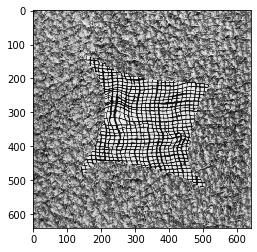

In [2]:
#fname = "data/simple_test.png"
fname = "data/overlap_test.png"
img = plt.imread(fname)
plt.imshow(img, cmap='gray')

In [3]:
def init_circle_curve(n_points, center, radius):
    th = np.arange(0,1,1/n_points)*(2*np.pi)
    snake = np.array([np.cos(th), np.sin(th)]).transpose()*radius + center
    return snake

def plot_snake(snake,col='blue'):
    plt.plot(*zip(*np.flip(snake,axis=1)),'.-',linewidth=1,color=col)
    
def plot_forces(snake, forces, factor):
    for i in range(len(snake)):
        d = forces[i,:]*factor
        plt.arrow(snake[i,1],snake[i,0],d[1],d[0], color='green')

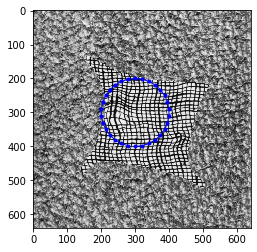

In [4]:
snake = init_circle_curve(30,(300,300),100)
plt.imshow(img, cmap='gray')
plot_snake(snake)

Find mask that describes the inner part of the snake:

In [5]:
def curve_normals(snake):
    a = np.zeros_like(snake)
    s_prev = np.roll(snake,  1, axis=0) # prev
    s_next = np.roll(snake, -1, axis=0) # next
    a[:,0] =   s_next[:,1] - s_prev[:,1]
    a[:,1] = -(s_next[:,0] - s_prev[:,0])
    a = a / np.linalg.norm(a, axis=1)[:,None]
    return a

In [6]:
from collections import deque

def pixels_between_points(p1, p2):
    vec = p2-p1
    l = np.linalg.norm(vec)
    p = np.arange(l)/l
    return (p1+p[:,None]*vec).astype(int)

def curve_contour(snake, mask_shape):
    mask = np.zeros(mask_shape).astype(bool)
    p = snake[-1,]
    for i in range(len(snake)):
        idx = pixels_between_points(p, snake[i,])
        p = snake[i,]
        mask[idx[:,0],idx[:,1]] = True
    return mask

def fill_contour(mask, seed):
    queue = deque([seed])
    while(queue):
        pt = queue.popleft()
        if(mask[pt[0],pt[1]] != True):
            mask[pt[0],pt[1]] = True
            # add neighbours to queue
            queue.append( (pt[0] - 1, pt[1]) )
            queue.append( (pt[0] + 1, pt[1]) )
            queue.append( (pt[0], pt[1] - 1) )
            queue.append( (pt[0], pt[1] + 1) )           
        
def snake_enclosed(snake, normals, img_shape):
    mask = curve_contour(snake, img_shape)
    p0 = tuple((snake[0,]-2*normals[0,]).astype(int))
    fill_contour(mask,p0)
    return mask.astype(bool)

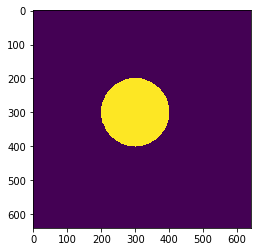

In [7]:
normals = curve_normals(snake)
mask = snake_enclosed(snake, normals, img.shape)
plt.imshow(mask)

Find which pixels intensities are found inside and outside the snake

In [8]:
all_unique = np.unique(img.flatten()) # array containing each different pixel value

count_inside = np.zeros_like(all_unique)
count_outside = np.zeros_like(all_unique)
count_total = np.zeros_like(all_unique)
for i,x in enumerate(all_unique):
    count_inside[i] = (img[mask]==x).sum()
    count_outside[i] = (img[~mask]==x).sum()
    count_total[i] = count_inside[i]+count_outside[i];

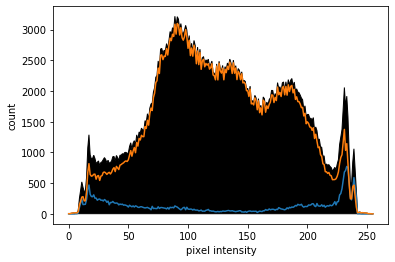

In [9]:
plt.fill(count_total, color='black')
plt.plot(count_inside)
plt.plot(count_outside)
plt.xlabel('pixel intensity')
plt.ylabel('count')
plt.show()

Scale according to inside/outside area

In [10]:
total_inside = mask.sum()
total_outside = img.size - total_inside
pixel_prc_in = count_inside/total_inside
pixel_prc_out = count_outside/total_outside

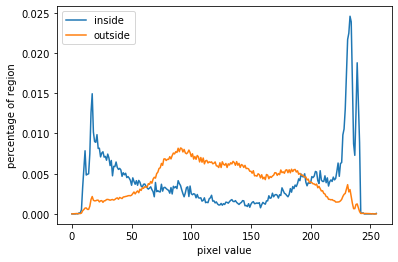

In [11]:
plt.plot(pixel_prc_in)
plt.plot(pixel_prc_out)
plt.xlabel('pixel value')
plt.ylabel('percentage of region')
plt.legend(['inside','outside'])
plt.show()

Calculate probalility of being inside contour based on pixel intensity

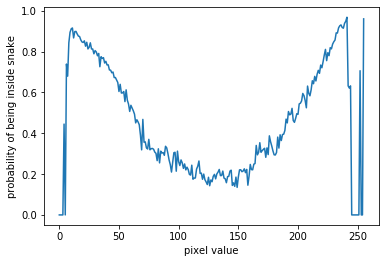

In [12]:
pixel_probs = pixel_prc_in / (pixel_prc_in+pixel_prc_out)
plt.plot(pixel_probs)
plt.xlabel('pixel value')
plt.ylabel('probability of being inside snake')
plt.show()

Plot as probability image

In [13]:
prob_img = np.zeros_like(img)
for i,x in enumerate(all_unique):
    prob_img[img==x] = pixel_probs[i]

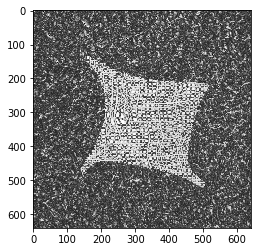

In [14]:
plt.imshow(prob_img, cmap='gray')

Reduce noie by snoothing

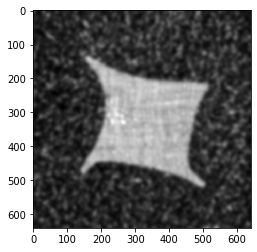

In [15]:
import scipy.ndimage as ndimage
prob_img_smooth = ndimage.gaussian_filter(prob_img, sigma=(5, 5), order=0)

# TODO Normalize ?

plt.imshow(prob_img_smooth, cmap='gray')

## Deform model on smoothed prob image

#### Wrap code in methods

In [17]:
from collections import deque
import snake_functions as sf

class deform_model():
    def __init__(self,n_points, center, radius, smooth_param):
        th = np.arange(0,1,1/n_points)*(2*np.pi)
        self.snake = np.array([np.cos(th), np.sin(th)]).transpose()*radius + center
        self.normals = self.compute_normals()
        self.smooth_mat = sf.smooth_matrix(n_points, smooth_param[0], smooth_param[1])

    def compute_normals(self):
        a = np.zeros_like(self.snake)
        s_prev = np.roll(self.snake,  1, axis=0) # prev
        s_next = np.roll(self.snake, -1, axis=0) # next
        a[:,0] =   s_next[:,1] - s_prev[:,1]
        a[:,1] = -(s_next[:,0] - s_prev[:,0])
        a = a / np.linalg.norm(a, axis=1)[:,None]
        return a
    
    def read_values(self,img):
        idx_xy = self.snake.astype(int)
        return (img[idx_xy[:,0], idx_xy[:,1]])

    def set_forces(self, forces):
        self.force_vecs = forces[:,None] * self.normals
        
    def update(self, step_size):
        self.snake += self.force_vecs*step_size
        self.regularize()
        self.normals = self.compute_normals()
        
    def regularize(self):
        self.snake[:,:] = self.smooth_mat.dot(self.snake)
        snakeT = sf.distribute_points(self.snake.T)
        snakeT = sf.remove_intersections(snakeT)
        self.snake[:,:] = snakeT.T
        
    def enclosed_mask(self, img_shape):
        mask = curve_contour(self.snake, img_shape)
        p0 = tuple((self.snake[0,]-2*self.normals[0,]).astype(int))
        fill_contour(mask,p0)
        return mask.astype(bool)     

In [18]:
def create_prob_image(img, mask):    
    all_unique = np.unique(img.flatten()) # array containing each different pixel value

    count_inside = np.zeros_like(all_unique)
    count_outside = np.zeros_like(all_unique)
    count_total = np.zeros_like(all_unique)
    for i,x in enumerate(all_unique):
        count_inside[i] = (img[mask]==x).sum()
        count_outside[i] = (img[~mask]==x).sum()
        count_total[i] = count_inside[i]+count_outside[i]
        
    total_inside = mask.sum()
    total_outside = img.size - total_inside
    pixel_prc_in = count_inside/total_inside
    pixel_prc_out = count_outside/total_outside
    
    pixel_probs = pixel_prc_in / (pixel_prc_in+pixel_prc_out)
    prob_img = np.zeros_like(img)
    for i,x in enumerate(all_unique):
        prob_img[img==x] = pixel_probs[i]
    prob_img = ndimage.gaussian_filter(prob_img, sigma=(5, 5), order=0)
    return prob_img


#### Open cv draw methods

In [28]:
import cv2

def draw_snake(img_out, snake, color=(255,0,0)):
    snake = np.flip(snake,axis=1)
    pt0 = snake[-1,:].astype(int)
    for i in range(len(snake)):
        pt1 = snake[i,:].astype(int)
        img_out = cv2.line(img_out, tuple(pt0), tuple(pt1), color, 1)
        img_out = cv2.circle(img_out, tuple(pt1), 2, color, cv2.FILLED, 1)
        pt0 = pt1
    return img_out 

def draw_forces(img_out, snake, forces, color=(255,0,0)):
    snake = np.flip(snake,axis=1)
    forces = np.flip(forces,axis=1)
    for i in range(len(snake)):
        pt = snake[i,:]
        pt2 = snake[i,:] + forces[i,]
        img_out = cv2.arrowedLine(img_out, tuple(pt.astype(int)), tuple(pt2.astype(int)), color, 1)
    return img_out 

def vis_snake(img, snake, forces={}, wait=30, color=(255,0,0), title="snake"):
    img_out = cv2.cvtColor(img,cv2.COLOR_GRAY2RGB)
    img_out = draw_snake(img_out, snake, color)
    if len(forces)>0:
        img_out = draw_forces(img_out, snake, forces, color=color)
    cv2.imshow(title, img_out)
    key = cv2.waitKey(wait)
    return key==27


#### Run

In [30]:
model = deform_model(n_points = 140, center = (200,300), radius = 100, smooth_param=(0.2,0.2))

i = 0
while(True):
    if(i%5==0): 
        prob_img_smooth = create_prob_image(img, model.enclosed_mask(img.shape))
    model.set_forces(model.read_values(prob_img_smooth) - 0.5)
    vis_snake(img, model.snake, wait=1, title="Original")
    if vis_snake(prob_img_smooth, model.snake, 200*model.force_vecs, wait=300, title="Probability"): break
    model.update(100)
    i+=1
    
cv2.destroyAllWindows()
cv2.waitKey(1);